In [2]:
%run qae_utils.py
from qae_utils import *
from qae_utils import state_preparation_ansatz
from typing import Iterable, Optional, Union
from scipy.optimize import minimize
from qiskit import *
from qiskit import execute

In [11]:
## define the grover operator ~
p = 0.2
initial_state_prep = s_psi0(p)
grv_op = Q(p, 1)

In [12]:
global verbose
verbose = True

#### #Phase0

In [15]:
qpe(0.25), qpe(0.25, trainable= True, p_param= 0.25)

NameError: name 'execute' is not defined

In [6]:
p_guess = 0.24
p= 0.25

r = minimize(to_minimize, p_guess, method= 'Nelder-Mead')

inside-> to_minimize
inside-> qpe
 'p'=   0.2
 'p_param'=  0.24
ourside-> qpe, p_est 0.23110780748033713
cost  [7.90710878e-05]
inside-> to_minimize
inside-> qpe
 'p'=   0.2
 'p_param'=  0.252
ourside-> qpe, p_est 0.25196112424756056
cost  [1.51132413e-09]
inside-> to_minimize
inside-> qpe
 'p'=   0.2
 'p_param'=  0.264
ourside-> qpe, p_est 0.27268432216212385
cost  [7.54174514e-05]
inside-> to_minimize
inside-> qpe
 'p'=   0.2
 'p_param'=  0.258
ourside-> qpe, p_est 0.26361983359248137
cost  [3.15825296e-05]
inside-> to_minimize
inside-> qpe
 'p'=   0.2
 'p_param'=  0.246
ourside-> qpe, p_est 0.23831954450323065
cost  [5.89893966e-05]
inside-> to_minimize
inside-> qpe
 'p'=   0.2
 'p_param'=  0.255
ourside-> qpe, p_est 0.2582073541804409
cost  [1.02871208e-05]
inside-> to_minimize
inside-> qpe
 'p'=   0.2
 'p_param'=  0.249
ourside-> qpe, p_est 0.25029731977205455
cost  [1.68303859e-06]
inside-> to_minimize
inside-> qpe
 'p'=   0.2
 'p_param'=  0.2505
ourside-> qpe, p_est 0.2492358577

In [7]:
qpe(0.25), qpe(0.25, trainable= True, p_param= r.x[0])

inside-> qpe
 'p'=   0.25
inside-> qpe
 'p'=   0.25
 'p_param'=  0.252


(0.248324447925864, 0.2559669994488036)

In [26]:
p_est

0.2511381850103768

#### #Phase1
Prepare PQC to assist the state perparation circuit to be used inside the Grover Operator, $ \mathcal{\hat{Q}_{\beta}} $, where $\beta$ in the set of trainable paramters. (** For single qubit states only; oracle $\mathcal{\hat{O}_{\ket{1}}} = \hat{Z}$ and $\mathcal{\hat{O}_{\ket{0}}} = -\hat{Z}$ ).

$$ \mathcal{\hat{Q}_{\beta}} =  (\mathbb{\hat{I}} - 2 \ket{\tilde{\psi_0}(\beta)} \bra{\tilde{\psi_0}(\beta)} ) \: \mathcal{\hat{O}}
$$

Here the $\ket{\tilde{\psi_0}(\beta)}$ is approximated initial state and is prepard using the PQC as 
$$      \ket{\tilde{\psi_0}(\beta)}\ket{\Gamma_{\beta}} = \mathcal{\hat{P}_{\beta}} ( \ket{0} \ket{\Gamma} )
$$
where $\Gamma$ denotes the ancilla qubits, and $\mathcal{\hat{P}_{\beta}}$ denotes the paramterised quantum circuit.

In [5]:
num_ancillas = 5

params_state = np.random.uniform(low=0, high= 2*pi, size= 2)
params_ancilla= np.random.uniform(low=0, high= 2*pi, size= 2*num_ancillas )

qreg = QuantumRegister(1, name= 'q')
ancillas = AncillaRegister(num_ancillas, name= 'ancilla')
qc = QuantumCircuit(qreg, ancillas)

## set_ansatz ~
qc.ry(params_state[0], qreg)
qc.cx(qreg, ancillas[0])

for index, ancilla in list(enumerate(ancillas))  :
    qc.ry(params_ancilla[index], ancilla)
    qc.cx(ancillas[index], ancillas[(index+1)%(num_ancillas)])
qc.barrier()
for index, ancilla in list(reversed(list(enumerate(ancillas))))  :
    qc.ry(params_ancilla[index], ancilla)
    qc.cx(ancillas[index], ancillas[(index-1)%(num_ancillas)])

qc.cx( ancillas[0], qreg)
qc.ry(params_state[1], qreg)


In [128]:
class state_preparation_ansatz(QuantumCircuit):
    
    def __init__(self,
        num_ancillas: int,
        name: str= "Q",
        params: Optional[Union[Iterable, str, None]]= "random",
        insert_barrier:bool= False)-> None:

        super().__init__(name= name)

        ## set inputs ~
        self._num_ancillas= num_ancillas
        self._name= name
        self._insert_barrier= insert_barrier
        self._params= params
        self._num_params = self._num_ancillas * 4 + 2

        ## build parameters ~
        qreg = QuantumRegister(1)
        ancillas = AncillaRegister(self._num_ancillas)
        qc = QuantumCircuit(qreg, ancillas)
        self.add_register(*qc.qregs)
        
        # self.draw(output= 'mpl') ##checkflag

        # self._build(self._params)
        ## load custom params ~
        # self.load_params(params)
        # self._build()
        

    @property
    def num_ancillas(self):
        """ No, of ancillas used in the ansatz """
        return self._num_ancillas
    
    @property
    def num_params(self):
        """ No. of parmaters passed into the ansatz """
        return self._num_params

    def load_params(self, params_to_load: Iterable):
        
        ## get list of tunable paramters ~
        param_data = [ data[0] for data in self.data if data[0].name== 'ry' ]
        for index, instrc in enumerate(param_data): 
            instrc.params = [ params_to_load[index]]

        return self

    def show_params(self):
        print("\n params_state: ", self._params_state)
        print("\n params_ancillas_init: ", self._params_ancilla_init)
        print("\n params_ancillas: ", self._params_ancilla)
        print("\n params_ancillas_end: ", self._params_ancilla_end)

    def _build(self, params):

        if isinstance(params, str) and params== "random":

            print(" 'random' ")
            self._params_state = np.random.uniform(low=0, high= 2*pi, size= 2)
            self._params_ancilla_1= np.random.uniform(low=0, high= 2*pi, size= self._num_ancillas )
            self._params_ancilla_2= np.random.uniform(low=0, high= 2*pi, size= self._num_ancillas )
            self._params_ancilla_init= np.random.uniform(low=0, high= 2*pi, size= self._num_ancillas )
            self._params_ancilla_end= np.random.uniform(low=0, high= 2*pi, size= self._num_ancillas )
            print(" 'params_ancilla_end': ", self._params_ancilla_end) ##checkflag
            
        elif isinstance(params, Iterable):

            if len(params) != self._num_params: raise ValueError(" no. of elements in 'params' must be ", self._num_params )
            self._params_state= np.append(params[0],params[-1])
            self._params_ancilla_init= params[1: 1 + self._num_ancillas]
            self._params_ancilla_1= params[1 + self._num_ancillas: 1 + 2 * self._num_ancillas]
            self._params_ancilla_2= params[1+ 2 * self._num_ancillas: 1 + 3 * self._num_ancillas]
            self._params_ancilla_end = params[1 + 3 * self._num_ancillas: -1]


        params_state = self._params_state
        params_ancilla_1= self._params_ancilla_1
        params_ancilla_2 = self._params_ancilla_2
        params_ancilla_init = self._params_ancilla_init
        params_ancilla_end = self._params_ancilla_end
        # print(" 'params_ancilla_end': ", self._params_ancilla_end) ##checkflag

        ancillas = self.ancillas
        qreg = self.qubits[0]

        ## set_ansatz ~
        self.h(ancillas)
        self.ry(params_state[0], qreg)

        for index, ancilla in list(enumerate(self.ancillas))  : self.ry(params_ancilla_init[index], ancilla)
        if self._insert_barrier == True: self.barrier()

        self.cx(qreg, ancillas[0])

        for index, ancilla in list(enumerate(ancillas))  :
            self.ry(params_ancilla_1[index], ancilla)
            self.cx(ancillas[index], ancillas[(index+1)%(self._num_ancillas)])
        
        if self._insert_barrier == True: self.barrier()
        
        for index, ancilla in list(reversed(list(enumerate(ancillas))))  :
            self.ry(params_ancilla_2[index], ancilla)
            self.cx(ancillas[index], ancillas[(index-1)%(self._num_ancillas)])

        self.cx( ancillas[0], qreg)
        
        if self._insert_barrier == True: self.barrier()     
        for index, ancilla in list(enumerate(ancillas))  : self.ry(params_ancilla_end[index], ancilla)   
     
        self.ry(params_state[1], qreg)
        self.h(ancillas)

        print(self.qubits) ## checkflag
        print(self.qubits) ## checkflag
        
        # self.draw() ## checkflag
        # if isinstance(params, str) and params== 'random':
        #     self.add_register(*self.qregs)

        print(self.qubits) ## checkflag
        print(self.qubits) ## checkflag

        
        # self.compose(self, qubits= self.qubits, inplace= True) ###checkflag
        return self

           

In [11]:
params = np.random.uniform(low= 0, high= 2 * pi, size= pqc.num_params)
params

array([1.62543189, 1.1098084 , 1.36329837, 5.96252773, 2.48059658,
       4.6143345 , 5.96872703, 4.36317102, 1.37179829, 1.49265031,
       3.99804082, 0.33300089, 0.62731506, 2.34370319, 0.39219029,
       2.65769981, 1.13075808, 4.67433267, 0.9372513 , 2.47069305,
       3.46415225, 2.00763285])

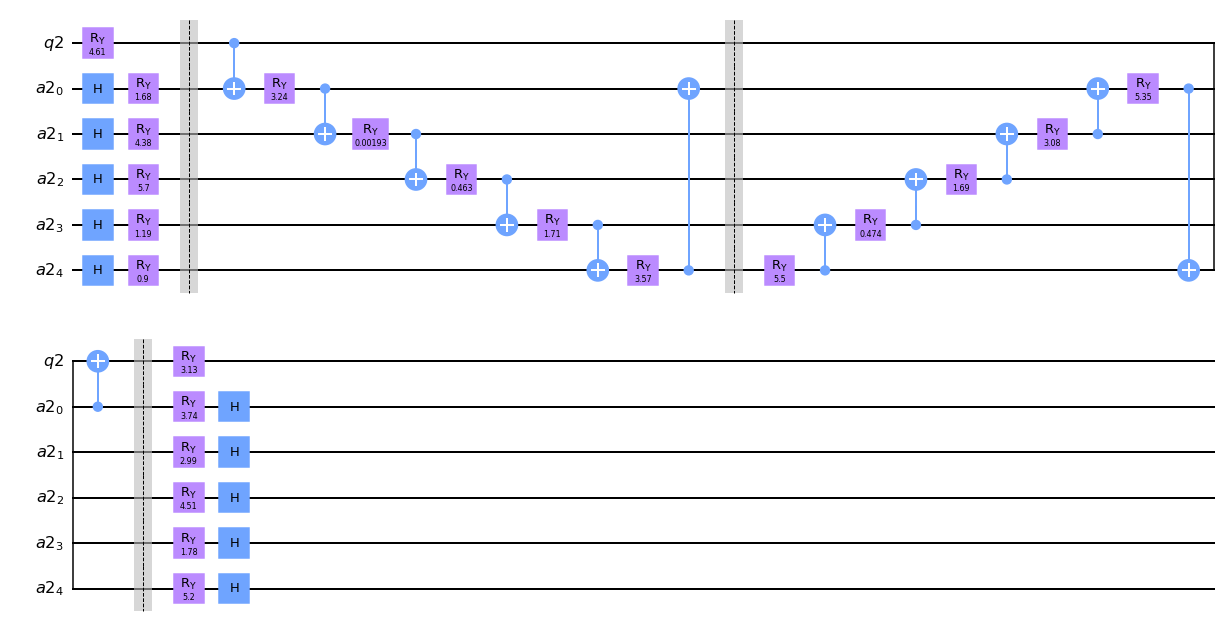

In [10]:
# pqc = state_preparation_ansatz(5, params= 'random', name= 'a', insert_barrier= True)
pqc._build(params= params)
pqc.draw(output='mpl')

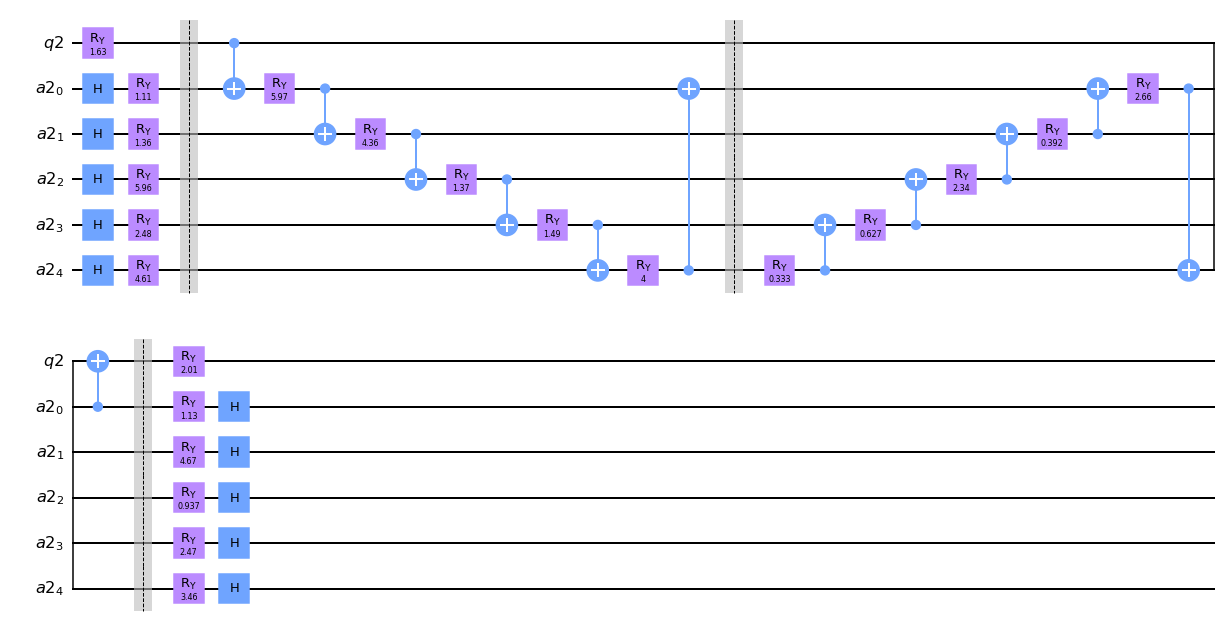

In [12]:
pqc_p = pqc.load_params(params)
pqc_p.draw(output='mpl')

In [13]:
def state_preparation_ansatz_fun(num_ancillas:int= 5, insert_barrier:bool= False)-> QuantumCircuit:
    r""" Circuit to prepare the paraterised 'QuantumCicruit' for preparing the initial state

        ARGS:
            

    """
    params_state = np.random.uniform(low=0, high= 2*pi, size= 2)
    params_ancilla= np.random.uniform(low=0, high= 2*pi, size= 2*num_ancillas )

    qreg = QuantumRegister(1, name= 'q')
    ancillas = AncillaRegister(num_ancillas, name= 'ancilla')
    qc = QuantumCircuit(qreg, ancillas)

    ## set_ansatz ~
    qc.ry(params_state[0], qreg)
    qc.cx(qreg, ancillas[0])

    for index, ancilla in list(enumerate(ancillas))  :
        qc.ry(params_ancilla[index], ancilla)
        qc.cx(ancillas[index], ancillas[(index+1)%(num_ancillas)])
    
    if insert_barrier== True: qc.barrier()
    
    for index, ancilla in list(reversed(list(enumerate(ancillas))))  :
        qc.ry(params_ancilla[index], ancilla)
        qc.cx(ancillas[index], ancillas[(index-1)%(num_ancillas)])

    qc.cx( ancillas[0], qreg)
    qc.ry(params_state[1], qreg)

    return qc

def load_state_preparation_ansatz(params:Iterable ):
    qc = state_preparation_ansatz()



In [ ]:
oracle = QuantumCircuit(1, name='oracle')
oracle.z(0)

state_preparation_circuit= state_preparation_ansatz_fun(insert_barrier= True)

In [ ]:
gr_op = GroverOperator(oracle, state_preparation= state_preparation_circuit, insert_barriers= True)

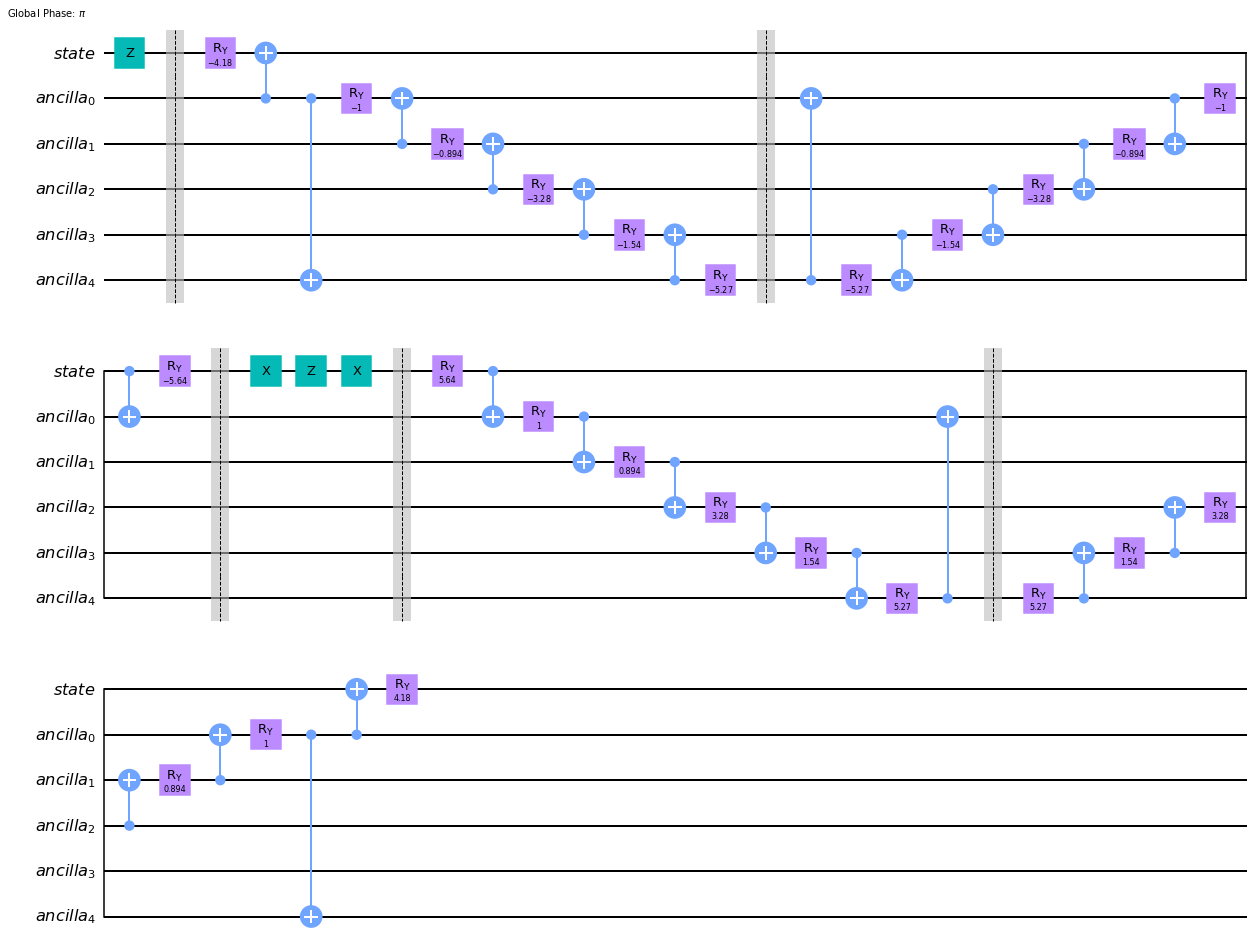

In [ ]:
gr_op.decompose().draw(output= 'mpl')

[AncillaQubit(AncillaRegister(5, 'ancilla'), 0),
 AncillaQubit(AncillaRegister(5, 'ancilla'), 1),
 AncillaQubit(AncillaRegister(5, 'ancilla'), 2),
 AncillaQubit(AncillaRegister(5, 'ancilla'), 3),
 AncillaQubit(AncillaRegister(5, 'ancilla'), 4)]